## Setup

In [1]:
!pip install surprise


     |████████████████████████████████| 11.8 MB 21.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630171 sha256=f1ed6e7bef4114d20f5a5bc52831995b651a393707042bde9593bf298e1f7d9e
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
import random

In [5]:
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/test.csv
!wget https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/train.csv

--2022-02-25 01:16:12--  https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1079198 (1.0M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1.03M  --.-KB/s    in 0.006s  

2022-02-25 01:16:12 (171 MB/s) - ‘data.csv.1’ saved [1079198/1079198]

--2022-02-25 01:16:13--  https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/miniproject2/data/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP reque

In [6]:
# Load data
df_data = pd.read_csv('data.csv')
df_movies = pd.read_csv('movies.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [23]:
df_data.head()

,User ID,Movie ID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


# Basic Visualizations

## 1. All ratings in the MovieLens Dataset.

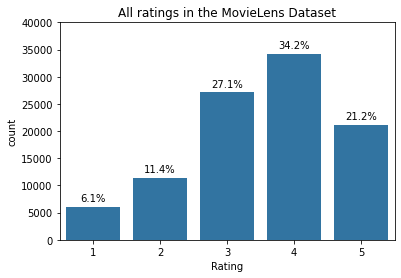

In [24]:
ax = sns.countplot(x="Rating", data=df_data, color = 'C0')
total = len(df_data)

max_height = 0
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 1000
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 40000))
plt.title('All ratings in the MovieLens Dataset')
plt.show()

## 2. All ratings of the ten most popular movies (movies which have received the most ratings).

In [25]:
movie_ratings = df_data.groupby('Movie ID').agg({'Rating': [np.size, np.mean]})

# sort by rating size
top_10_popular_stats = movie_ratings.sort_values([('Rating', 'size')], ascending=False)[:10]
top_10_popular_stats

Rating          
           size      mean
Movie ID                 
50          583  4.358491
258         509  3.803536
100         508  4.155512
181         507  4.007890
294         485  3.156701
286         481  3.656965
288         478  3.441423
1           452  3.878319
300         431  3.631090
121         429  3.438228

In [26]:
top_10_popular_movies = df_movies[df_movies['Movie ID'].isin(top_10_popular_stats.index)]['Movie Title']
top_10_popular_movies

0                   Toy Story (1995)
49                  Star Wars (1977)
99                      Fargo (1996)
120    Independence Day (ID4) (1996)
180        Return of the Jedi (1983)
257                   Contact (1997)
285      English Patient, The (1996)
287                    Scream (1996)
293                 Liar Liar (1997)
299             Air Force One (1997)
Name: Movie Title, dtype: object

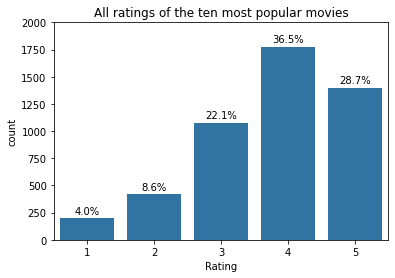

In [27]:
# First find the ten most popular movies
top_10_popular = df_data[df_data['Movie ID'].isin(top_10_popular_stats.index)]

# Plot the histogram on the ten most popular movies
ax = sns.countplot(x="Rating", data=top_10_popular, color = 'C0')
total = len(top_10_popular)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 40
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 2000))
plt.title('All ratings of the ten most popular movies')
plt.show()

## 3. All ratings of the ten best movies (movies with the highest average ratings).

In [28]:
movie_ratings = df_data.groupby('Movie ID').agg({'Rating': [np.size, np.mean]})

# sort by rating average
movie_ratings.sort_values([('Rating', 'mean')], ascending=False).head()

Rating     
           size mean
Movie ID            
814           1  5.0
1599          1  5.0
1201          1  5.0
1122          1  5.0
1653          1  5.0

Many movies that have a 5.0 rating have too few data samples, so they should be ruled out for best rated movies. Only movies that have more than 50 ratings will be considered

In [29]:
atleast_50 = movie_ratings['Rating']['size'] >= 50
top_10_best_stats = movie_ratings[atleast_50].sort_values([('Rating', 'mean')], ascending=False)[:10]
top_10_best_stats

Rating          
           size      mean
Movie ID                 
408         112  4.491071
318         298  4.466443
169         118  4.466102
483         243  4.456790
114          67  4.447761
64          283  4.445230
603         209  4.387560
12          267  4.385768
50          583  4.358491
178         125  4.344000

In [30]:
top_10_best_movies = df_movies[df_movies['Movie ID'].isin(top_10_best_stats.index)]['Movie Title']
top_10_best_movies

11                            Usual Suspects, The (1995)
49                                      Star Wars (1977)
63                      Shawshank Redemption, The (1994)
113    Wallace & Gromit: The Best of Aardman Animatio...
168                           Wrong Trousers, The (1993)
177                                  12 Angry Men (1957)
317                              Schindler's List (1993)
407                                Close Shave, A (1995)
482                                    Casablanca (1942)
602                                   Rear Window (1954)
Name: Movie Title, dtype: object

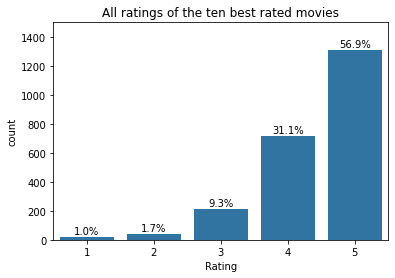

In [31]:
# First find the ten best rated movies
top_10_best = df_data[df_data['Movie ID'].isin(top_10_best_stats.index)]

# Plot the histogram on the ten most popular movies
ax = sns.countplot(x="Rating", data=top_10_best, color = 'C0')
total = len(top_10_best)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 1500))
plt.title('All ratings of the ten best rated movies')
plt.show()

## 4. All ratings of movies from three genres of your choice (create three separate visualizations).

In [32]:
df_movies.columns

Index(['Movie ID', 'Movie Title', 'Unknown', 'Action', 'Adventure',
       'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

### Drama Movies

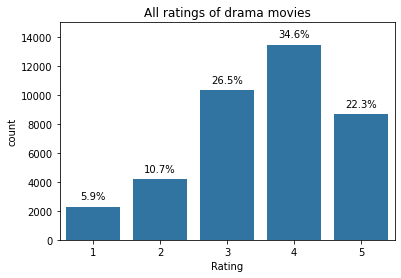

In [33]:
# First find all the drama movies
df_drama_id = df_movies[df_movies['Drama'] == 1].index
df_drama = df_data[df_data['Movie ID'].isin(df_drama_id)]

# Plot the histogram on all the drama movies
ax = sns.countplot(x="Rating", data=df_drama, color = 'C0')
total = len(df_drama)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 500
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 15000))
plt.title('All ratings of drama movies')
plt.show()

### Sci-Fi Movies

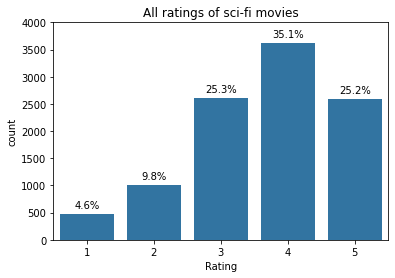

In [34]:
# First find all the sci-fi movies
df_sci_id = df_movies[df_movies['Sci-Fi'] == 1].index
df_sci = df_data[df_data['Movie ID'].isin(df_sci_id)]

# Plot the histogram on all the sci-fi movies
ax = sns.countplot(x="Rating", data=df_sci, color = 'C0')
total = len(df_sci)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 100
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 4000))
plt.title('All ratings of sci-fi movies')
plt.show()

### Comedy Movies

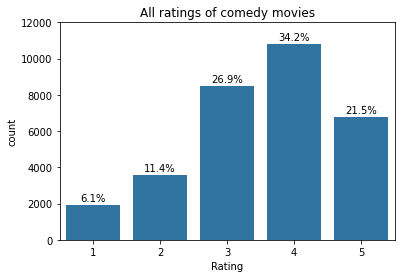

In [35]:
# First find all the comedy movies
df_comedy_id = df_movies[df_movies['Comedy'] == 1].index
df_comedy = df_data[df_data['Movie ID'].isin(df_comedy_id)]

# Plot the histogram on all the comedy movies
ax = sns.countplot(x="Rating", data=df_comedy, color = 'C0')
total = len(df_comedy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 200
    ax.annotate(percentage, (x, y),ha='center')

ax.set(ylim=(0, 12000))
plt.title('All ratings of comedy movies')
plt.show()

# Matrix Factorization Visualizations

## 1. Using modified code from homework 5

In [1]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U^T), a training point Yij, the column
    vector Vj (jth column of V), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (reg*Ui - Vj * (Yij - np.dot(Ui, Vj))) * eta

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V), a training point Yij,
    Ui (the ith row of U^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (reg*Vj - Ui * (Yij - np.dot(Ui, Vj))) * eta

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U^T and the jth column of V.
    """
    Y_pred = np.dot(U.T,V)
    error = reg/2*(np.linalg.norm(U)**2+np.linalg.norm(V)**2)
    for y in Y:
        y_pred = Y_pred[y[0]-1,y[1]-1]
        error += 1/2*(y_pred-y[2])**2
    error /= len(Y)

    return error

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    K x M matrix U and K x N matrix V such that rating Y_ij is approximated
    by (U^TV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    U = np.random.random((K,M)) - 0.5
    V = np.random.random((K,N)) - 0.5
    error = []
    for epoch in range(max_epochs):
        np.random.shuffle(Y)
        for y in Y:
            Ui = U[:,y[0]-1]
            Vj = V[:,y[1]-1]
            gU = grad_U(Ui, y[2], Vj, reg, eta)
            gV = grad_V(Vj, y[2], Ui, reg, eta)
            U[:,y[0]-1] -= gU
            V[:,y[1]-1] -= gV
        err = get_err(U, V, Y, reg)
        error.append(err)
        if epoch >= 2 and (error[-1]-error[-2])/(error[1]-error[0]) <= eps:
            break
    
    return (U,V,error[-1])


Cross-validation to tune the hyperparamters. Don't need to run every time

Factorizing with  943  users,  1682  movies.
The best value of reg is  0.1 at E_out of  0.4478435737525178


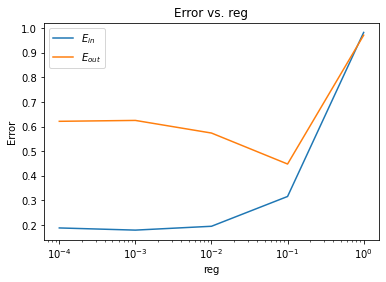

In [19]:
Y_train = df_train.to_numpy()
Y_test = df_test.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]

K = 20
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    U,V, err = train_model(M, N, K, eta, reg, Y_train)
    E_in.append(err)
    E_out.append(get_err(U, V, Y_test))

print('The best value of reg is ', regs[np.argmin(E_out)], 'at E_out of ', np.min(E_out))

# Visualize the results
plt.xscale('log')
plt.plot(regs, E_in, label='$E_{in}$')
plt.plot(regs, E_out, label='$E_{out}$')
plt.title('Error vs. reg')
plt.savefig('error_vs_reg_hw5.png')
plt.xlabel('reg')
plt.ylabel('Error')
plt.legend()

The above cross-validation gives the best regularization parameter

In [7]:
Y_train = df_train.to_numpy()
Y_test = df_test.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20
eta = 0.03 # learning rate
reg = 0.1
print('U, V obtained with the following hyperparameters: K = %d, eta = %.2f, reg = %.1f' %(K,eta,reg))
U,V,_ = train_model(M, N, K, eta, reg, Y_train)

U, V obtained with the following hyperparameters: K = 20, eta = 0.03, reg = 0.1


Prepare Factorization for Vizualization

In [8]:
A,S,B = np.linalg.svd(V)
V_tilde = np.dot(A[:,:2].T, V)
U_tilde = np.dot(A[:,:2].T, U)

V_tilde.shape, U_tilde.shape

((2, 1682), (2, 943))

Rescaling

In [9]:
# Remove the mean
V_tilde -= np.mean(V_tilde, axis=1, keepdims=True)
U_tilde -= np.mean(U_tilde, axis=1, keepdims=True)

# Scale to have unit variance
V_tilde = V_tilde / np.std(V_tilde, axis=1, keepdims=True)
U_tilde = U_tilde / np.std(U_tilde, axis=1, keepdims=True)

## 2. Using Surprise SVD (with bias terms)

In [10]:
# Convert data to data type accepted by Surpise SVD
reader = Reader(rating_scale=(1, 5))

#df_train[['Movie ID', 'Rating','User ID']] needs to be loaded in this order 
SP_train_dataset = Dataset.load_from_df(df_train[['User ID',  'Movie ID',  'Rating']], reader)
SP_train_trainset = SP_train_dataset.build_full_trainset()
SP_train_trainset.n_items = 1682 #Have to add this because the Test set does not have all of the movie IDs

SP_test_dataset = Dataset.load_from_df(df_test[['User ID',  'Movie ID',  'Rating']], reader)
SP_test_trainset = SP_test_dataset.build_full_trainset()
SP_test_testset = SP_test_trainset.build_testset()

In [11]:
#Code to convert the U and V matricies of Surprise SVD to the same format as problem set 5
def convert_suprise_SVD_U_raw(U,trainset):
  U_raw = np.zeros(U.shape)
  for i in range(U.shape[0]):
    U_raw[trainset.to_raw_uid(i)-1] = U[i]
  return U_raw

def convert_suprise_SVD_V_raw(V,trainset):
  all_items = np.array(list(trainset.all_items()))#list of all inner ids
  V_raw = np.zeros((trainset.n_items,V.shape[1]))
  convert_dict = trainset._inner2raw_id_items
  for i in all_items:
    if trainset.knows_item(i):
      V_raw[trainset.to_raw_iid(i)-1] = V[i]
    else: print('Inner Index: ',i, 'was not included in train set')
  return V_raw

### Do a grid search for optimal parameters 

In [25]:
param_grid = {'n_epochs': [25, 50], 
              'n_factors' : [20],
              'lr_all' : [0.01,.1],
              'reg_all': [.001, 0.01,0.1,.5, .7],
              'biased' : [True]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(SP_train_dataset)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9185330166241961
{'n_epochs': 50, 'n_factors': 20, 'lr_all': 0.01, 'reg_all': 0.1, 'biased': True}


### Use full Training Set with optimal parameters
Calculate U and V <br>
Test With Test Set

In [12]:
algo_biased = SVD(n_factors=20, biased=True, n_epochs = 50, lr_all = .01, reg_all = .1,random_state=7)

algo_biased.fit(SP_train_trainset)

predict_biased = algo_biased.test(SP_test_testset)
surprise.accuracy.rmse(predict_biased, verbose=True)

U_biased = algo_biased.pu
V_biased = algo_biased.qi

U_biased_raw = convert_suprise_SVD_U_raw(U_biased,SP_train_trainset)
U_biased_raw = U_biased_raw.T
V_biased_raw = convert_suprise_SVD_V_raw(V_biased,SP_train_trainset)
V_biased_raw = V_biased_raw.T

RMSE: 0.9064
Inner Index:  1668 was not included in train set
Inner Index:  1669 was not included in train set
Inner Index:  1670 was not included in train set
Inner Index:  1671 was not included in train set
Inner Index:  1672 was not included in train set
Inner Index:  1673 was not included in train set
Inner Index:  1674 was not included in train set
Inner Index:  1675 was not included in train set
Inner Index:  1676 was not included in train set
Inner Index:  1677 was not included in train set
Inner Index:  1678 was not included in train set
Inner Index:  1679 was not included in train set
Inner Index:  1680 was not included in train set
Inner Index:  1681 was not included in train set


Prepare Biased Factorization for Vizualization

In [13]:
A_biased,S_biased,B_biased = np.linalg.svd(V_biased_raw)

V_tilde_biased = np.dot(A_biased[:,:2].T, V_biased_raw)
U_tilde_biased = np.dot(A_biased[:,:2].T, U_biased_raw)
V_tilde_biased.shape, U_tilde_biased.shape


((2, 1682), (2, 943))

Rescaling

In [14]:
# Remove the mean
V_tilde_biased -= np.mean(V_tilde_biased, axis=1, keepdims=True)
U_tilde_biased -= np.mean(U_tilde_biased, axis=1, keepdims=True)

# Scale to have unit variance
V_tilde_biased = V_tilde_biased / np.std(V_tilde_biased, axis=1, keepdims=True)
U_tilde_biased = U_tilde_biased / np.std(U_tilde_biased, axis=1, keepdims=True)

## 3. Using Surprise SVD (without bias terms)

In [29]:
param_grid_unbiased = {'n_epochs': [25, 50], 
              'n_factors' : [5, 10, 15, 20, 30],
              'lr_all' : [0.01,.1],
              'reg_all': [.001, 0.01,0.1,.5, .7],
              'biased' : [False]}
gs_unbiased = GridSearchCV(SVD, param_grid_unbiased, measures=['rmse', 'mae'], cv=5)

gs_unbiased.fit(SP_train_dataset)

# best RMSE score
print(gs_unbiased.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_unbiased.best_params['rmse'])

0.9272744440471345
{'n_epochs': 50, 'n_factors': 30, 'lr_all': 0.01, 'reg_all': 0.1, 'biased': False}


In [49]:
algo_unbiased = SVD(n_factors=30, biased=False, n_epochs = 50, lr_all = .01, reg_all = .1,random_state=7)

algo_unbiased.fit(SP_train_trainset)

predict_unbiased = algo_unbiased.test(SP_test_testset)
surprise.accuracy.rmse(predict_unbiased, verbose=True)

U_unbiased = algo_unbiased.pu
V_unbiased = algo_unbiased.qi

U_unbiased_raw = convert_suprise_SVD_U_raw(U_unbiased,SP_train_trainset)
U_unbiased_raw = U_unbiased_raw.T
V_unbiased_raw = convert_suprise_SVD_V_raw(V_unbiased,SP_train_trainset)
V_unbiased_raw = V_unbiased_raw.T

RMSE: 0.9149
Inner Index:  1668 was not included in train set
Inner Index:  1669 was not included in train set
Inner Index:  1670 was not included in train set
Inner Index:  1671 was not included in train set
Inner Index:  1672 was not included in train set
Inner Index:  1673 was not included in train set
Inner Index:  1674 was not included in train set
Inner Index:  1675 was not included in train set
Inner Index:  1676 was not included in train set
Inner Index:  1677 was not included in train set
Inner Index:  1678 was not included in train set
Inner Index:  1679 was not included in train set
Inner Index:  1680 was not included in train set
Inner Index:  1681 was not included in train set


Prepare Biased Factorization for Vizualization

In [50]:
A_unbiased,S_unbiased,B_unbiased = np.linalg.svd(V_unbiased_raw)

V_tilde_unbiased = np.dot(A_unbiased[:,:2].T, V_unbiased_raw)
U_tilde_unbiased = np.dot(A_unbiased[:,:2].T, U_unbiased_raw)
V_tilde_unbiased.shape, U_tilde_unbiased.shape


((2, 1682), (2, 943))

Rescaling

In [51]:
# Remove the mean
V_tilde_unbiased -= np.mean(V_tilde_unbiased, axis=1, keepdims=True)
U_tilde_unbiased -= np.mean(U_tilde_unbiased, axis=1, keepdims=True)

# Scale to have unit variance
V_tilde_unbiased = V_tilde_unbiased / np.std(V_tilde_unbiased, axis=1, keepdims=True)
U_tilde_unbiased = U_tilde_unbiased / np.std(U_tilde_unbiased, axis=1, keepdims=True)

# Performance of Methods

In [18]:
# Same metric as for Surprise 
#(only work for unbiased, need to add bias terms to y_pred if want to evaluate bias)
def rmse(U,V,Y):
  sum = 0.0
  Y_pred = np.dot(U.T,V)
  for y in Y:
      y_pred = Y_pred[y[0]-1,y[1]-1]
      sum += (y[2]-y_pred)**2

  return np.sqrt((1/len(Y))*sum)

def mae(U,V,Y):
  sum = 0.0
  Y_pred = np.dot(U.T,V)
  for y in Y:
      y_pred = Y_pred[y[0]-1,y[1]-1]
      sum += np.abs(y[2]-y_pred)

  return (1/len(Y))*sum

In [19]:
print('hw 5 unbiased')
print('rmse', rmse(U,V,Y_test))
print('mae', mae(U,V,Y_test))
print()

# Just to check the values align with the Surprise calculated values (they do)
print('unbiased surprise')
print('rmse', rmse(U_unbiased_raw,V_unbiased_raw,Y_test))
print('mae', mae(U_unbiased_raw,V_unbiased_raw,Y_test))
print()


hw 5 unbiased
rmse 0.945785986279861
mae 0.7468596718478514

unbiased surprise
rmse 0.9181348032863066
mae 0.7258212205283653



In [20]:
# Printing previous results for comparison
print('Surprise Unbiased')
surprise.accuracy.rmse(predict_unbiased, verbose=True)
surprise.accuracy.mae(predict_unbiased, verbose=True)

print('Surprise Biased')
surprise.accuracy.rmse(predict_biased, verbose=True)
surprise.accuracy.mae(predict_biased, verbose=True)

Surprise Unbiased
RMSE: 0.9149
MAE:  0.7237
Surprise Biased
RMSE: 0.9064
MAE:  0.7136


0.7136223527642391

# Visualization

In [21]:
# Note the discrepancy between movie title and ID here
df_movies['Movie Title'].nunique(), df_movies['Movie ID'].nunique()

(1664, 1682)

In [36]:
movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
movies_num_ratings = movie_ratings.Rating['size'].to_numpy()

## All Movies

Note that the sign of the principal components are determined randomly during fitting for surprise SVD. Each time, we may have to flip the signs of each principal components to match the results that we get from using the set 5 codes.

In [54]:
#V_tilde_unbiased[0] = -V_tilde_unbiased[0]
V_tilde_unbiased[1] = -V_tilde_unbiased[1]

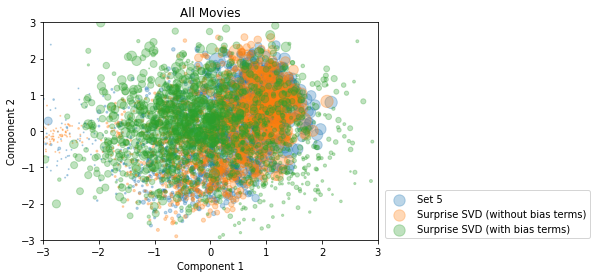

In [56]:
# Dot size depends on average ratings
plt.scatter(V_tilde[0], V_tilde[1], marker = '.', label = 'Set 5', s=4**movies_avg_ratings, alpha=0.3)
plt.scatter(V_tilde_unbiased[0], V_tilde_unbiased[1], marker='.', label= 'Surprise SVD (without bias terms)', s=4**movies_avg_ratings, alpha=0.3)
plt.scatter(V_tilde_biased[0], V_tilde_biased[1], marker='.', label= 'Surprise SVD (with bias terms)', s=4**movies_avg_ratings, alpha=0.3)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend(loc='upper right',bbox_to_anchor=(1.65, 0.25))
plt.title('All Movies')
plt.show()

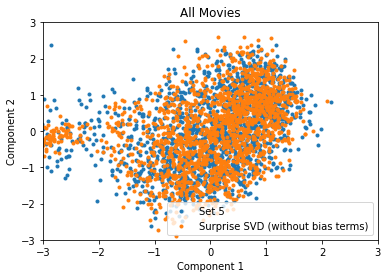

In [55]:
# Plot to see that results using set 5 codes are similar to surprise SVD without bias term
plt.scatter(V_tilde[0], V_tilde[1], marker = '.', label = 'Set 5')
plt.scatter(V_tilde_unbiased[0], V_tilde_unbiased[1], marker='.', label= 'Surprise SVD (without bias terms)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend(loc='best')
plt.title('All Movies')
plt.show()

### Model 1: Codes from set 5 (without bias terms)

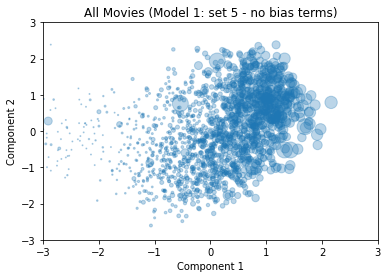

In [57]:
# Dot size depends on average ratings
plt.scatter(V_tilde[0], V_tilde[1], marker = '.', s=4**movies_avg_ratings, alpha=0.3, color='C0')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('All Movies (Model 1: set 5 - no bias terms)')
plt.show()

### Model 2: Surprise SVD - with bias terms

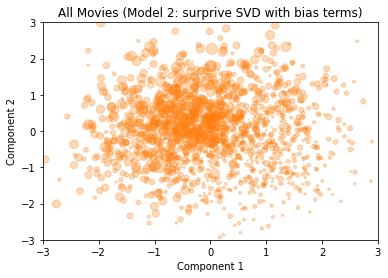

In [58]:
# Dot size depends on average ratings
plt.scatter(V_tilde_biased[0], V_tilde_biased[1], marker='.', s=4**movies_avg_ratings, alpha=0.3, color='C1')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('All Movies (Model 2: surprive SVD with bias terms)')
plt.show()

### Model 2: Surprise SVD - without bias terms

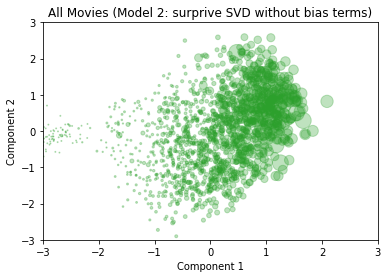

In [59]:
# Dot size depends on average ratings
plt.scatter(V_tilde_unbiased[0], V_tilde_unbiased[1], marker='.', s=4**movies_avg_ratings, alpha=0.3, color='C2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title('All Movies (Model 2: surprive SVD without bias terms)')
plt.show()

## Interesting visualization (for Piazza post)

In [60]:
genre = ['Action','Drama']
df_plot = pd.DataFrame([], columns=['Component 1', 'Component 2', 'Genre'])
for ii in range(len(genre)):
    movies = df_movies[df_movies[genre[ii]]==1]['Movie Title'].unique()
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde_biased[:,movies_id-1]
    df_temp = pd.DataFrame(np.transpose(movies_V), columns=['Component 1', 'Component 2'])
    df_temp['Genre'] = genre[ii]
    movies_avg_ratings = movie_ratings.Rating['mean'][movies_id].to_numpy()
    df_temp['avg_ratings'] = movies_avg_ratings
    movies_num_ratings = movie_ratings.Rating['size'][movies_id].to_numpy()
    df_temp['num_ratings'] = movies_num_ratings
    df_plot = df_plot.append(df_temp)

df_plot.reset_index(inplace=True, drop=True)

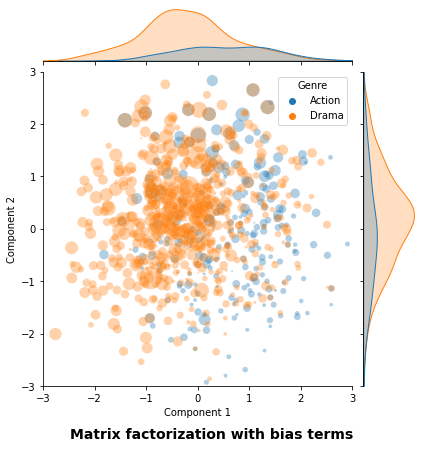

In [61]:
plot = sns.jointplot(data=df_plot, x="Component 1", y="Component 2", hue='Genre', s=3.5**df_plot['avg_ratings'], alpha=0.35)
plot.ax_marg_x.set_xlim(-3, 3)
plot.ax_marg_y.set_ylim(-3, 3)
plt.suptitle("Matrix factorization with bias terms", y=0, fontsize=14, fontweight='bold')
plt.show()

In [62]:
genre = ['Action','Drama']
df_plot = pd.DataFrame([], columns=['Component 1', 'Component 2', 'Genre'])
for ii in range(len(genre)):
    movies = df_movies[df_movies[genre[ii]]==1]['Movie Title'].unique()
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde[:,movies_id-1]
    df_temp = pd.DataFrame(np.transpose(movies_V), columns=['Component 1', 'Component 2'])
    df_temp['Genre'] = genre[ii]
    movies_avg_ratings = movie_ratings.Rating['mean'][movies_id].to_numpy()
    df_temp['avg_ratings'] = movies_avg_ratings
    movies_num_ratings = movie_ratings.Rating['size'][movies_id].to_numpy()
    df_temp['num_ratings'] = movies_num_ratings
    df_plot = df_plot.append(df_temp)

df_plot.reset_index(inplace=True, drop=True)

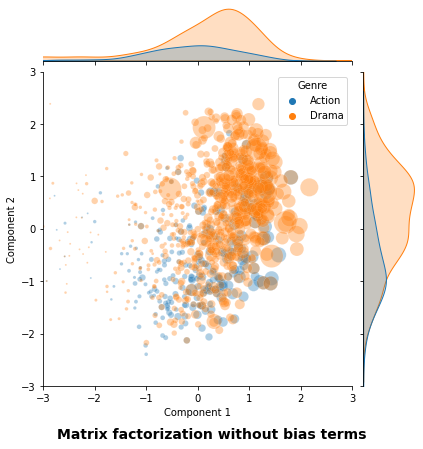

In [63]:
plot = sns.jointplot(data=df_plot, x="Component 1", y="Component 2", hue='Genre', s=3.5**df_plot['avg_ratings'], alpha=0.35)
plot.ax_marg_x.set_xlim(-3, 3)
plot.ax_marg_y.set_ylim(-3, 3)
plt.suptitle("Matrix factorization without bias terms", y=0, fontsize=14, fontweight='bold')
plt.show()

## Selected Movies

###Make Visualization Code For Each Function

In [64]:
def visualizeV(movies, movies_label, title):
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde[:,movies_id-1]

    plt.figure(figsize=(8,6))

    # Plot all movies
    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde[0], V_tilde[1], marker = '.', s=2*movies_num_ratings, alpha=0.3, c=movies_avg_ratings)

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 1: set 5 - no bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

In [65]:
def visualizeV_genre(movies, movies_label, title, genre):

    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde[:,movies_id-1]

    plt.figure(figsize=(8,6))

    # Plot movies belong in a genre
    movies_genre = df_movies[df_movies[genre]==1]['Movie Title'].unique()
    movies_id_genre = df_movies[df_movies['Movie Title'].isin(movies_genre)]['Movie ID'].to_numpy()
    movies_V_genre = V_tilde[:,movies_id_genre-1]

    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde[0,movies_id_genre-1], V_tilde[1,movies_id_genre-1], marker = '.', s=2*movies_num_ratings[movies_id_genre-1], alpha=0.3, c=movies_avg_ratings[movies_id_genre-1])

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 1: set 5 - no bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

In [66]:
def visualizeV_biased_surprise(movies, movies_label, title):
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V =V_tilde_biased[:,movies_id-1]

    plt.figure(figsize=(8,6))
    
    # Plot all movies
    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde_biased[0], V_tilde_biased[1], marker = '.', s=2*movies_num_ratings, alpha=0.3, c=movies_avg_ratings)

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 2: surprise SVD with bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

In [67]:
def visualizeV_biased_surprise_genre(movies, movies_label, title, genre):
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V =V_tilde_biased[:,movies_id-1]

    plt.figure(figsize=(8,6))
    
    # Plot movies belong in a genre
    movies_genre = df_movies[df_movies[genre]==1]['Movie Title'].unique()
    movies_id_genre = df_movies[df_movies['Movie Title'].isin(movies_genre)]['Movie ID'].to_numpy()
    movies_V_genre = V_tilde[:,movies_id_genre-1]

    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde_biased[0,movies_id_genre-1], V_tilde_biased[1,movies_id_genre-1], marker = '.', s=2*movies_num_ratings[movies_id_genre-1], alpha=0.3, c=movies_avg_ratings[movies_id_genre-1])

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 2: surprise SVD with bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

In [68]:
def visualizeV_unbiased_surprise(movies, movies_label, title):
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde_unbiased[:,movies_id-1]

    plt.figure(figsize=(8,6))
    
    # Plot all movies
    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde_unbiased[0], V_tilde_unbiased[1], marker = '.', s=2*movies_num_ratings, alpha=0.3, c=movies_avg_ratings)

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 2: surprise SVD without bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

In [69]:
def visualizeV_unbiased_surprise_genre(movies, movies_label, title, genre):
    movies_id = df_movies[df_movies['Movie Title'].isin(movies)]['Movie ID'].to_numpy()
    movies_V = V_tilde_unbiased[:,movies_id-1]

    plt.figure(figsize=(8,6))
    
    # Plot movies belong in a genre
    movies_genre = df_movies[df_movies[genre]==1]['Movie Title'].unique()
    movies_id_genre = df_movies[df_movies['Movie Title'].isin(movies_genre)]['Movie ID'].to_numpy()
    movies_V_genre = V_tilde[:,movies_id_genre-1]

    movies_avg_ratings = movie_ratings.Rating['mean'].to_numpy()
    movies_num_ratings = movie_ratings.Rating['size'].to_numpy()
    plt.scatter(V_tilde_unbiased[0,movies_id_genre-1], V_tilde_unbiased[1,movies_id_genre-1], marker = '.', s=2*movies_num_ratings[movies_id_genre-1], alpha=0.3, c=movies_avg_ratings[movies_id_genre-1])

    # Superimpose 10 movies of interest
    plt.scatter(movies_V[0], movies_V[1], marker = 'x', s=50, color='black')
    for i, txt in enumerate(movies_label):
        plt.annotate(txt, (movies_V[0][i] + 0.1, movies_V[1][i] + 0.1))
    plot_title = title + ' (Model 2: surprise SVD without bias terms)'
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(plot_title, fontweight='bold')
    cbar = plt.colorbar()
    cbar.set_label('Average Ratings')
    plt.clim(0,5) 
    plt.savefig(plot_title.replace(' ', '')+'.png')

### (a) Any ten movies of your choice from the MovieLens dataset.

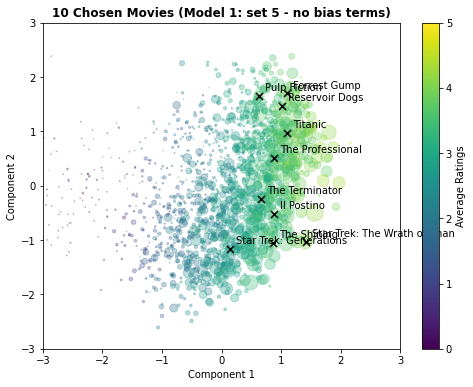

In [70]:
movies = ['Pulp Fiction (1994)', 'Professional, The (1994)', 'Forrest Gump (1994)',
          'Shining, The (1980)', 'Reservoir Dogs (1992)', 'Postino, Il (1994)', 
          'Titanic (1997)','Terminator, The (1984)','Star Trek: The Wrath of Khan (1982)','Star Trek: Generations (1994)']
movies_label = ['Pulp Fiction', 'The Professional', 'Forrest Gump',
          'The Shining', 'Reservoir Dogs', 'Il Postino', 
          'Titanic','The Terminator','Star Trek: The Wrath of Khan','Star Trek: Generations']
title = '10 Chosen Movies'          

visualizeV(movies, movies_label, title)

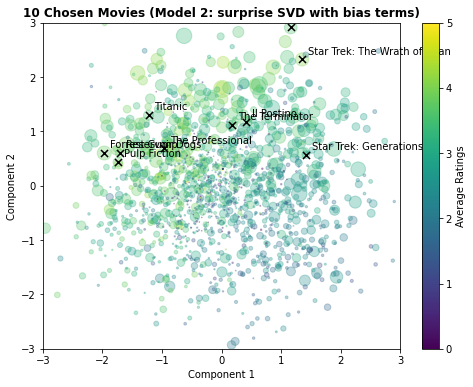

In [71]:
visualizeV_biased_surprise(movies, movies_label, title)

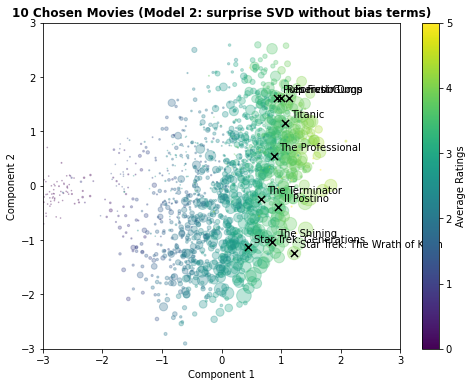

In [72]:
visualizeV_unbiased_surprise(movies, movies_label, title)

### (b) The ten most popular movies (movies which have received the most ratings).

In [73]:
movies = top_10_popular_movies.to_list()
movies

['Toy Story (1995)',
 'Star Wars (1977)',
 'Fargo (1996)',
 'Independence Day (ID4) (1996)',
 'Return of the Jedi (1983)',
 'Contact (1997)',
 'English Patient, The (1996)',
 'Scream (1996)',
 'Liar Liar (1997)',
 'Air Force One (1997)']

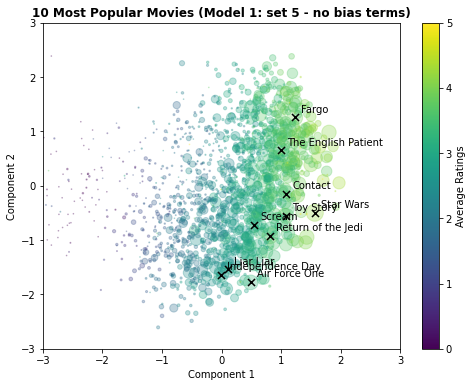

In [74]:
movies_label =['Toy Story', 'Star Wars', 'Fargo', 'Independence Day',
               'Return of the Jedi', 'Contact', 'The English Patient',
               'Scream', 'Liar Liar', 'Air Force One']
title = '10 Most Popular Movies'
visualizeV(movies, movies_label, title)

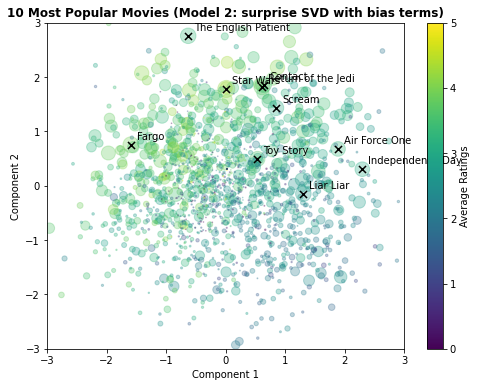

In [75]:
visualizeV_biased_surprise(movies, movies_label, title)

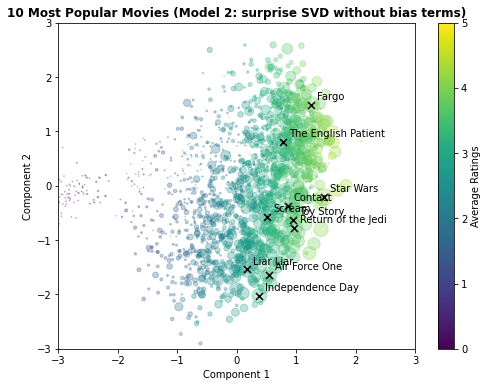

In [76]:
visualizeV_unbiased_surprise(movies, movies_label, title)

### (c) The ten best movies (movies with the highest average ratings).

In [77]:
movies = top_10_best_movies.to_list()
movies

['Usual Suspects, The (1995)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Wrong Trousers, The (1993)',
 '12 Angry Men (1957)',
 "Schindler's List (1993)",
 'Close Shave, A (1995)',
 'Casablanca (1942)',
 'Rear Window (1954)']

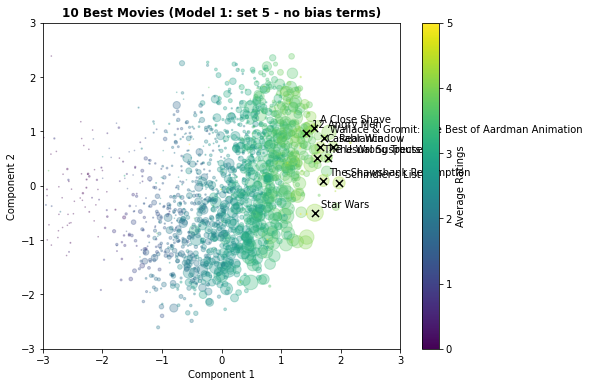

In [78]:
movies_label = ['The Usual Suspects', 'Star Wars', 'The Shawshank Redemption',
                'Wallace & Gromit: The Best of Aardman Animation', 'The Wrong Trousers',
                '12 Angry Men', "Schindler's List", 'A Close Shave', 'Casablanca', 'Rear Window']
title = '10 Best Movies'
visualizeV(movies, movies_label, title)

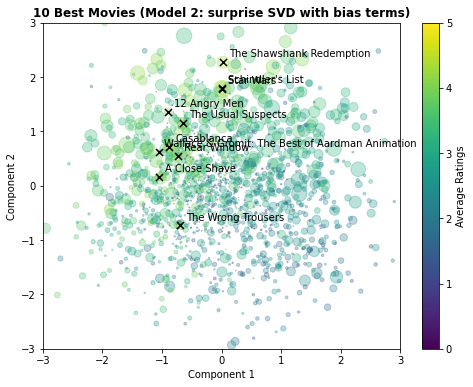

In [79]:
visualizeV_biased_surprise(movies, movies_label, title)

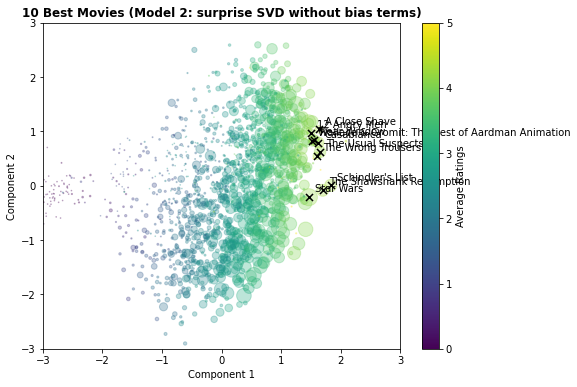

In [80]:
visualizeV_unbiased_surprise(movies, movies_label, title)

### (d) Ten movies from the three genres you selected in Section 4, Basic Visualizations (for a total of 30 movies). Create one visualization, containing ten movies, for each of the three genres you select.

#### Drama

In [81]:
drama_movie_ratings = df_drama.groupby('Movie ID').agg({'Rating': [np.size, np.mean]})

# sort by rating size
drama_top_10_popular_stats = drama_movie_ratings.sort_values([('Rating', 'size')], ascending=False)[:10]
drama_top_10_popular_movies = df_movies[df_movies['Movie ID'].isin(drama_top_10_popular_stats.index)]['Movie Title']
movies = drama_top_10_popular_movies.to_list()
movies

['Twelve Monkeys (1995)',
 'Star Wars (1977)',
 'Pulp Fiction (1994)',
 'Return of the Jedi (1983)',
 'Back to the Future (1985)',
 'Star Trek: First Contact (1996)',
 'Men in Black (1997)',
 'Full Monty, The (1997)',
 'English Patient, The (1996)',
 'Scream (1996)']

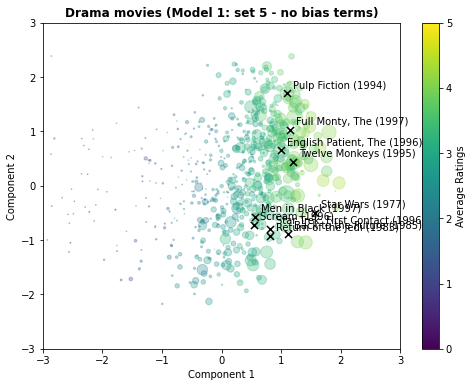

In [82]:
title = 'Drama movies'
visualizeV_genre(movies, movies, title, 'Drama')

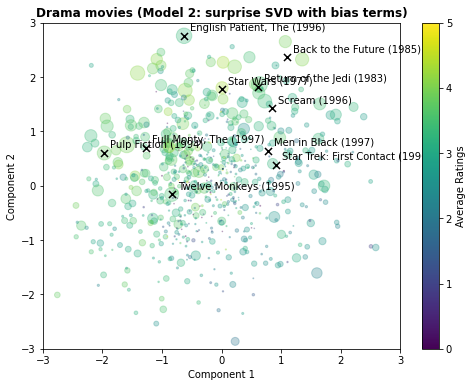

In [83]:
visualizeV_biased_surprise_genre(movies, movies, title, 'Drama')

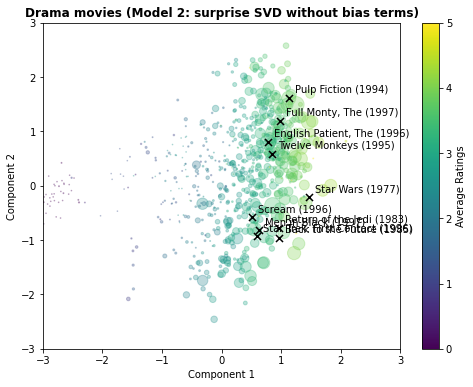

In [84]:
visualizeV_unbiased_surprise_genre(movies, movies, title, 'Drama')

#### Sci-Fi

In [85]:
sci_movie_ratings = df_sci.groupby('Movie ID').agg({'Rating': [np.size, np.mean]})

# sort by rating size
sci_top_10_popular_stats = sci_movie_ratings.sort_values([('Rating', 'size')], ascending=False)[:10]
sci_top_10_popular_movies = df_movies[df_movies['Movie ID'].isin(sci_top_10_popular_stats.index)]['Movie Title']
movies = sci_top_10_popular_movies.to_list()
movies


['Fargo (1996)',
 'Willy Wonka and the Chocolate Factory (1971)',
 'Raiders of the Lost Ark (1981)',
 'Alien (1979)',
 'Star Trek: The Wrath of Khan (1982)',
 'Jaws (1975)',
 'Raising Arizona (1987)',
 'Men in Black (1997)',
 'Full Monty, The (1997)',
 "One Flew Over the Cuckoo's Nest (1975)"]

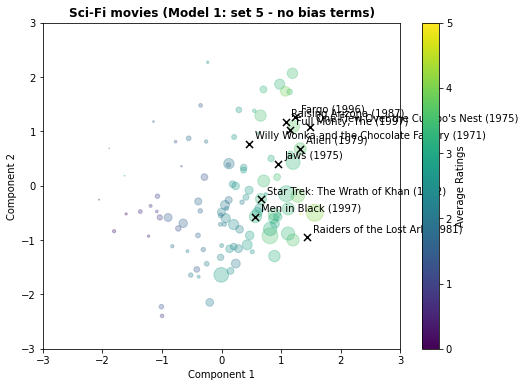

In [86]:
title = 'Sci-Fi movies'
visualizeV_genre(movies, movies, title, 'Sci-Fi')

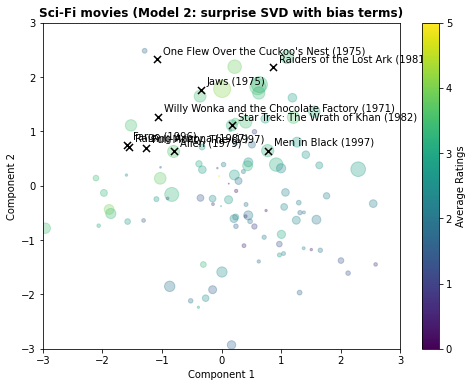

In [87]:
visualizeV_biased_surprise_genre(movies, movies, title, 'Sci-Fi')

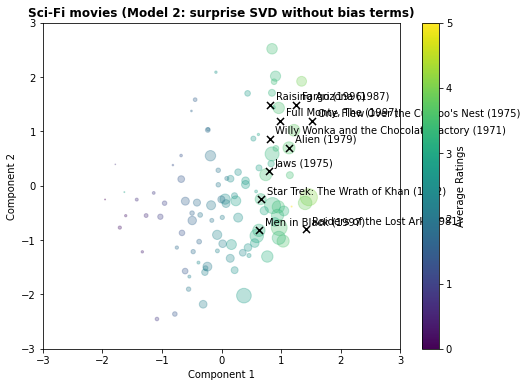

In [88]:
visualizeV_unbiased_surprise_genre(movies, movies, title, 'Sci-Fi')

#### Comedy

In [89]:
comedy_movie_ratings = df_comedy.groupby('Movie ID').agg({'Rating': [np.size, np.mean]})

# sort by rating size
comedy_top_10_popular_stats = comedy_movie_ratings.sort_values([('Rating', 'size')], ascending=False)[:10]
comedy_top_10_popular_movies = df_movies[df_movies['Movie ID'].isin(comedy_top_10_popular_stats.index)]['Movie Title']
movies = comedy_top_10_popular_movies.to_list()
movies


['Twelve Monkeys (1995)',
 'Forrest Gump (1994)',
 'Fugitive, The (1993)',
 'Independence Day (ID4) (1996)',
 'Willy Wonka and the Chocolate Factory (1971)',
 'Empire Strikes Back, The (1980)',
 'Indiana Jones and the Last Crusade (1989)',
 'Jerry Maguire (1996)',
 'Contact (1997)',
 'Air Force One (1997)']

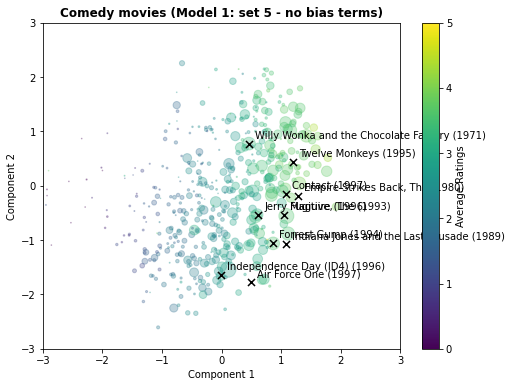

In [90]:
title = 'Comedy movies'
visualizeV_genre(movies,movies, title, 'Comedy')

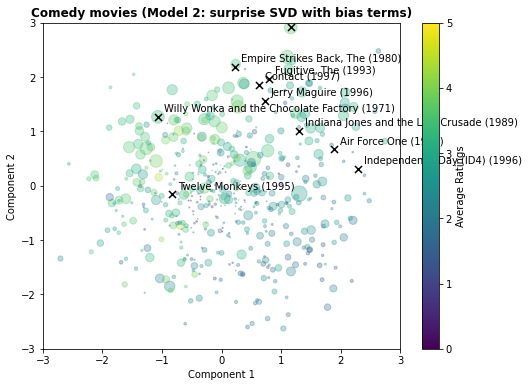

In [91]:
visualizeV_biased_surprise_genre(movies, movies, title, 'Comedy')

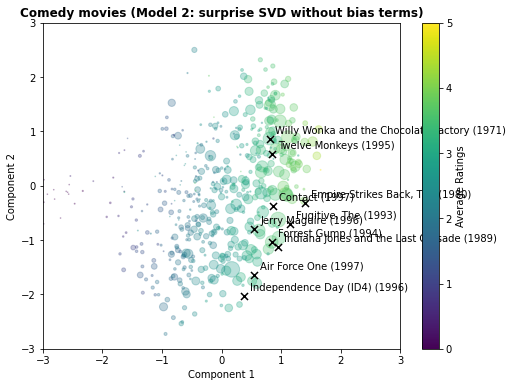

In [92]:
visualizeV_unbiased_surprise_genre(movies, movies, title, 'Comedy')